**Постановка задачи**  

Провести оценку результатов A/B-теста. 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько
вспомогательных датасетов. Оцените корректность проведения теста и проанализируйте его результаты.  

Чтобы оценить корректность проведения теста:
   - удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
   - проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.
   
**Техническое задание**  

**Название теста**: recommender_system_test;  
**Группы**: А (контрольная), B (новая платёжная воронка);  
**Дата запуска**: 2020-12-07;  
**Дата остановки набора новых пользователей**: 2020-12-21;  
**Дата остановки**: 2021-01-04;  
**Ожидаемое количество участников теста**: 15% новых пользователей из региона EU;  
**Назначение теста**: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;  
**Ожидаемый эффект**: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:  
   - конверсии в просмотр карточек товаров — событие product_page
   - просмотры корзины — product_cart
   - покупки — purchase .

In [1]:
# Загружаем библиотеки
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt
from pandas.plotting import register_matplotlib_converters

In [2]:
# Указываем базовые настройки 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
register_matplotlib_converters()

In [3]:
# Указываем настройки графиков
large = 16; med = 10; small = 8
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (10, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
sns.set_style("whitegrid")
%matplotlib inline

In [4]:
# Указываем путь к файлу
try:
    marketing_events, new_users, events, participants = (
        pd.read_csv('C:/Users/Boris/Desktop/datasets/ab_project_marketing_events.csv'),
        pd.read_csv('C:/Users/Boris/Desktop/datasets/final_ab_new_users.csv'),
        pd.read_csv('C:/Users/Boris/Desktop/datasets/final_ab_events.csv'),
        pd.read_csv('C:/Users/Boris/Desktop/datasets/final_ab_participants.csv')
    )
except:
    marketing_events, new_users, events, participants = (
        pd.read_csv('/datasets/ab_project_marketing_events.csv'),
        pd.read_csv('/datasets/final_ab_new_users.csv'),
        pd.read_csv('/datasets/final_ab_events.csv'),
        pd.read_csv('/datasets/final_ab_participants.csv')
    )

## Предварительная обработка данных

Проведем предварительную обработку данных для имеющихся наборов данных:

In [5]:
# Зададим функцию с параметрами необходимого набора данных
def first_look(df):
    
    # Сделаем новый набор данных, в который будет добавлять искомые значения
    fl_df = pd.DataFrame(columns=list(df.columns))
    
    # Начнем итерировать по колонкам набора данных
    for column in df.columns:
        fl_df.loc[1, column] = df[column].nunique()
        fl_df.loc[2, column] = df[column].isna().sum()
        fl_df.loc[3, column] = round(df[column].isna().sum() / len(df[column]), 4) * 100
        fl_df.loc[4, column] = df[column].duplicated().sum()
        fl_df.loc[5, column] = round(df[column].duplicated().sum() / len(df[column]), 4) * 100
    
    # Переименуем индексы строк
    fl_df.index = ['Уникальные значения',
                   'Пропуски',
                   'Пропуски, %',
                   'Дубликаты',
                   'Дубликаты, %']
    
    print('Выводим информацию о наборе данных:', '\n')
    df.info()
    
    # Выводим получившийся набор данных
    return display(fl_df)

### Обработка marketing_events

In [6]:
first_look(marketing_events)

Выводим информацию о наборе данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
Уникальные значения,14,6,14,14
Пропуски,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00
Дубликаты,0,8,0,0
"Дубликаты, %",0.00,57.14,0.00,0.00


Получили предварительную информацию о имеющиемся наборе данных.

In [7]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

Приведем столбцы к нужному формату

In [8]:
marketing_events['start_dt']=pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt']=pd.to_datetime(marketing_events['finish_dt'])

### Обработка new_users

In [9]:
first_look(new_users)

Выводим информацию о наборе данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
Уникальные значения,61733,17,4,4
Пропуски,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00
Дубликаты,0,61716,61729,61729
"Дубликаты, %",0.00,99.97,99.99,99.99


Получили предварительную информацию о имеющиемся наборе данных.  
Приведем столбцы к нужному формату:

In [10]:
new_users['first_date']=pd.to_datetime(new_users['first_date'])

### Обработка events

In [11]:
first_look(events)

Выводим информацию о наборе данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
Уникальные значения,58703,267268,4,4
Пропуски,0,0,0,377577
"Пропуски, %",0.00,0.00,0.00,85.75
Дубликаты,381614,173049,440313,440312
"Дубликаты, %",86.67,39.30,100.00,100.00


Получили предварительную информацию о имеющиемся наборе данных.  
Приведем столбцы к нужному формату:

In [12]:
events['event_dt']=pd.to_datetime(events['event_dt'])

### Обработка participants

In [13]:
first_look(participants)

Выводим информацию о наборе данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
Уникальные значения,16666,2,2
Пропуски,0,0,0
"Пропуски, %",0.00,0.00,0.00
Дубликаты,1602,18266,18266
"Дубликаты, %",8.77,99.99,99.99


Получили предварительную информацию о имеющиемся наборе данных. Пользователи могут попадать в несколько групп сразу, поэтому дубликаты в столбце user_id убирать не будем.

### Вывод по разделу

Была проведена предварительная обработка данных:
   - Просмотрены пропуски и дубликаты;
   - Приведены столбцы к нужному формату.

## Оценка корректности проведения теста

Необходимо выделить пользователей участвующих в тесте и проверить параметры.

Зададим необходимые параметры в соответсвии с тех.заданием:

In [14]:
# Сделаем срез по нужному тесту
rst=participants.query('ab_test == "recommender_system_test"')
# Добавим новых пользователей
rst=rst.merge(new_users[['user_id', 'first_date', 'region']],
              on='user_id',
              how='left')
rst.head(3)

,user_id,group,ab_test,first_date,region
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU


### Период набора пользователей

In [15]:
# Зададим начало и окончание исследований, которое нам дано по тех.заданию
start=dt.date(2020, 12, 7)
finish=dt.date(2021, 1, 4)
finish_regist=dt.date(2020, 12, 21)

In [16]:
print(f'Дата начала тестов {rst["first_date"].min()}')
print(f'Дата окончания тестов тестов {rst["first_date"].max()}')

Дата начала тестов 2020-12-07 00:00:00
Дата окончания тестов тестов 2020-12-21 00:00:00


Даты начала и окончания регистрации при тестировании подтверждены.

### Регион регистрации пользователей

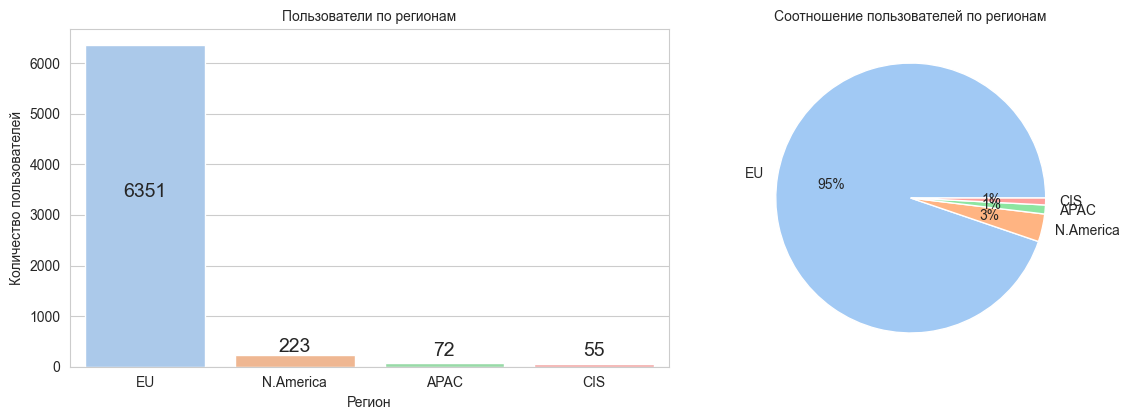

In [17]:
reg=rst.groupby('region')['user_id'].count().reset_index().sort_values(by='user_id',ascending=False)

fig,(ax1,ax2)=plt.subplots(1, 2,
                           figsize=(12, 4),
                           gridspec_kw={'width_ratios':[1, 1]})

ax1=sns.barplot(data=reg,
                x='region',
                y='user_id',
                palette='pastel',
                ax=ax1)
# Делаем подписи
for bar in ax1.patches:
    ax1.annotate(format(bar.get_height(),'.0f'),
                        (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()//2), ha='center', va='center',
                        size=14, xytext=(0, 10),
                        textcoords='offset points')

ax1.set_xlabel('Регион')   
ax1.set_ylabel('Количество пользователей')
ax1.set_title('Пользователи по регионам')
    
ax2.pie(reg['user_id'], 
        labels =reg['region'],
        colors = sns.color_palette('pastel'),
        autopct ='%.0f%%')
ax2.set_title('Соотношение пользователей по регионам')
plt.tight_layout(pad=0)
plt.show()

Как мы видим, больше всего пользователей из Европы, дальше идёт Северная Америка, потом Азиатско-Тихоокеанский регион и СНГ. 

Посмотрим сколько новых пользователей зарегистрировалось в Европе в интересующие нас даты:

In [24]:
len(new_users.query('(user_id in @rst["user_id"]) and (region == "EU") and \
                     (first_date <= @finish_regist) and (first_date >= @start)'))\
/len(new_users.query('(region == "EU") and (first_date <= @finish_regist) and \
                     (first_date >= @start)'))

0.15

Ровно 15 процентов, как по ТЗ

### Динамика набора пользователей

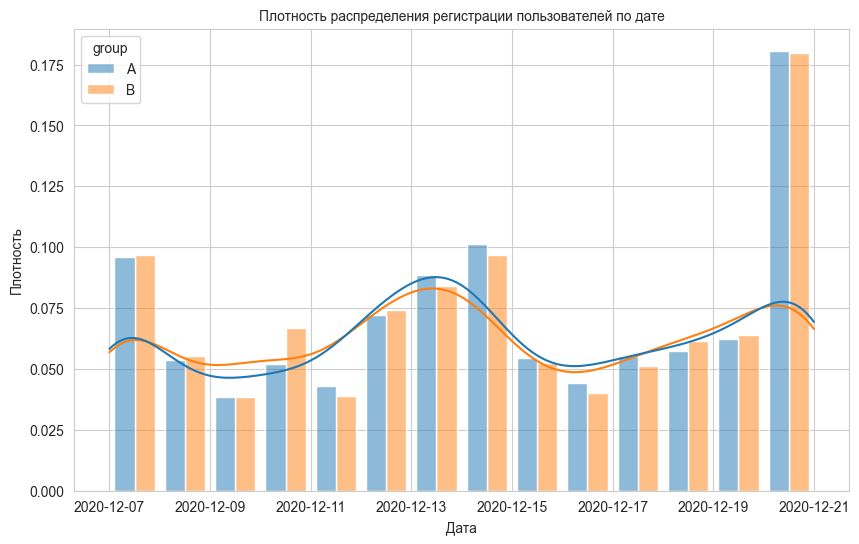

In [19]:
# Строим график плотности пользователей в зависимости от даты регистрации
sns.histplot(data=rst,
             x='first_date',
             bins=14,
             stat='density',
             common_norm=False,
             hue='group',
             multiple='dodge',
             shrink=0.8,
             kde=True)
plt.title('Плотность распределения регистрации пользователей по дате')
plt.xlabel('Дата')
plt.ylabel('Плотность')
plt.show()

Как мы видим было несколько колебаний графика регистрации пользователей, тем не менее, обе группы показывают очень схожие результаты.

### Пересекающиеся пользователи

Проверим наличие пользователей, которые состоят в двух группах одновременно:

In [20]:
# находим пересечение множеств пользователей групп
intersection = list(
    set(rst.query('group == \"A\"')['user_id'].unique()) & 
    set(rst.query('group == \"B\"')['user_id'].unique())
)
print('Колличество пользователей в обеих группах', len(intersection))

Колличество пользователей в обеих группах 0


Пересечений в группах нет

### Пересекающиеся события

Проверим какие события проходили в интересующие нас даты:

In [21]:
marketing_events.loc[(marketing_events['start_dt']>='2020-12-07') & 
                     (marketing_events['start_dt']<='2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Как мы видим, было 2 события в эти даты.

### Пересечение с конкурирующим тестом

In [22]:
intersection=participants.query('ab_test != "recommender_system_test" and \
                                 user_id in @rst["user_id"]')
intersection['user_id'].count()

1602

Как мы видим, 1602 пользователя попали в обе группы.

## Пользовательская активность